In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn import naive_bayes, svm
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

Pipeline   
1. Data loading
2. Preprocessing and encoding
3. Using model for classification (NaiveBayes and SVM)
4. Saving results

### Load data

In [72]:
data =  pd.read_csv("dataset/train.tsv",sep='\t',header=0)
print(data.head())
X = data['title']
y = data['is_fake'].array

#make sure that there is no class imbalance
print(len(y[y==0])/len(y))

                                               title  is_fake
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1
1  Агент Кокорина назвал езду по встречке житейск...        0
2  Госдума рассмотрит возможность введения секрет...        1
3  ФАС заблокировала поставку скоростных трамваев...        0
4  Против Навального завели дело о недоносительст...        1
0.5


###  Preprocessing  (lemmatization and stop words removal)

In [48]:
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(input_text):
    tokens = mystem.lemmatize(input_text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation
              and token.find('«') != -1
              and token.find('»') != -1]
    
    input_text = " ".join(tokens)
    
    return input_text

def preprocess_text_with_stopwords(input_text):
    tokens = mystem.lemmatize(input_text.lower())
    tokens = [token for token in tokens if token != " " \
              and token.strip() not in punctuation]
    
    input_text = " ".join(tokens)
    
    return input_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dyush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
preprocess_text_with_stopwords("«Пачка гречки за прививку»: Минздрав объявил о новой акции для пенсионеров")

'« пачка гречка за прививка »:  минздрав объявлять о новый акция для пенсионер'

#### Stemming

In [50]:
def preprocess__stem_text(input_text):
    from nltk.stem.snowball import SnowballStemmer 
    stemmer = SnowballStemmer("russian") 
    tokens = stemmer.stem(input_text.lower())
    stemmed_text = "".join(tokens)
    
    return stemmed_text

In [51]:
X_processed = X.apply(preprocess_text_with_stopwords)
print(X[0])
print(X_processed[0])
df = pd.DataFrame()
df['title'] = X_processed
df.to_csv('processed text with stop words.csv')

Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы
москвич владимир клутин приходить счет за вмешательство в американский выборы


In [52]:
df = pd.read_csv('processed text with stop words.csv')
X = df['title']
X_processed_stemmed = X.apply(preprocess__stem_text)
print(X[0])
print(X_processed_stemmed[0])
df = pd.DataFrame()
df['title'] = X_processed_stemmed
df.to_csv('processed and stemmed with stop words.csv')

москвич владимир клутин приходить счет за вмешательство в американский выборы
москвич владимир клутин приходить счет за вмешательство в американский выбор


### Using only lemmatization without stop words removal show better f1-score results, so I will use this option

In [73]:
df = pd.read_csv('processed text with stop words.csv')
X = df['title']

### Train - test split    

In [156]:
X_raw_train, X_raw_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

###  Count encoding (shows better f1 score on voting classifier)

In [157]:
vectorizer = CountVectorizer() # TfidfVectorizer - another option
X_train = vectorizer.fit_transform(X_raw_train)
feature_names = vectorizer.get_feature_names_out()
print(feature_names)
X_test = vectorizer.transform(X_raw_test)

['00' '02м' '08м' ... 'яценюк' 'яшин' 'ящик']


ngram ranges (2,2) (1,2) shows worse results so will be used default param value

## 1. Support Vector Machine:

In [162]:
SVM = svm.SVC(probability=True)#probability=True required for soft voting classifier
parametrs = {
    'C':[1.0,1.5,2,2.5],
    'degree': [3,5,7],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['scale','auto']
}

gs_clf_svc = GridSearchCV(SVM,parametrs,cv=3,scoring='f1',verbose=3)
gs_clf_svc.fit(X_train, y_train)
print(gs_clf_svc.best_estimator_)
print(gs_clf_svc.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END C=1.0, degree=3, gamma=scale, kernel=linear;, score=0.794 total time=   4.8s
[CV 2/3] END C=1.0, degree=3, gamma=scale, kernel=linear;, score=0.827 total time=   4.8s
[CV 3/3] END C=1.0, degree=3, gamma=scale, kernel=linear;, score=0.827 total time=   4.5s
[CV 1/3] END C=1.0, degree=3, gamma=scale, kernel=poly;, score=0.163 total time=   5.1s
[CV 2/3] END C=1.0, degree=3, gamma=scale, kernel=poly;, score=0.149 total time=   5.1s
[CV 3/3] END C=1.0, degree=3, gamma=scale, kernel=poly;, score=0.141 total time=   5.0s
[CV 1/3] END C=1.0, degree=3, gamma=scale, kernel=rbf;, score=0.831 total time=   4.5s
[CV 2/3] END C=1.0, degree=3, gamma=scale, kernel=rbf;, score=0.838 total time=   4.3s
[CV 3/3] END C=1.0, degree=3, gamma=scale, kernel=rbf;, score=0.848 total time=   4.4s
[CV 1/3] END C=1.0, degree=3, gamma=scale, kernel=sigmoid;, score=0.801 total time=   3.4s
[CV 2/3] END C=1.0, degree=3, gamma=scale, kernel=si

In [163]:
print(gs_clf_svc.score(X_test,y_test))

0.8278457196613358


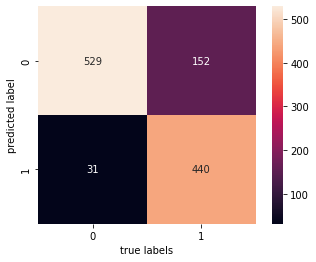

In [164]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,gs_clf_svc.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

## 2. Naive bayes

### Fine tune alpha and fit_prior params

In [165]:
clf = naive_bayes.MultinomialNB()
parametrs = {
    'alpha':[0.001,0.05,0.01,0.45,0.5,0.75,1],
    'fit_prior':[False,True]
}
gs_mnb_clf = GridSearchCV(clf,parametrs,cv=3,scoring='f1')
gs_mnb_clf.fit(X_train, y_train)
print("cv = 3: ",gs_mnb_clf.best_params_)
print(gs_mnb_clf.score(X_test,y_test))

gs_mnb_clf = GridSearchCV(clf,parametrs,cv=10,scoring='f1')
gs_mnb_clf.fit(X_train, y_train)
print("cv = 10: ",gs_mnb_clf.best_params_)
print(gs_mnb_clf.score(X_test,y_test))

cv = 3:  {'alpha': 0.45, 'fit_prior': True}
0.8776508972267536
cv = 10:  {'alpha': 0.5, 'fit_prior': True}
0.8776508972267536


### Let's compare confusion matricies  

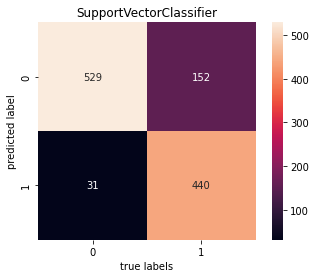

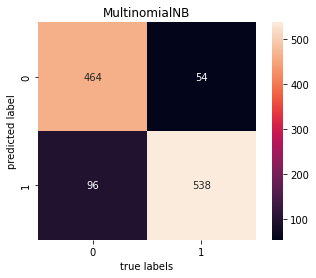

In [166]:
from sklearn.metrics import confusion_matrix


mat = confusion_matrix(y_test,gs_clf_svc.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.title("SupportVectorClassifier")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

mat = confusion_matrix(y_test,gs_mnb_clf.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.title("MultinomialNB")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

### Let's use voting classifer: models architecture different so results should be better 

In [167]:
eclf = VotingClassifier(estimators=[('svc', gs_clf_svc.best_estimator_), ('mnb', gs_mnb_clf.best_estimator_)],voting='soft')
eclf = eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)
print(f1_score(y_test,y_pred))
print("voting classifier, cv f1-score",cross_val_score(eclf,X_train,y_train,cv=3,scoring='f1').mean())
print("Multinominal Naive Bayes, cv f1-score",cross_val_score(gs_mnb_clf,X_train,y_train,cv=3,scoring='f1').mean())
print("SVC, cv f1-score",cross_val_score(gs_clf_svc.best_estimator_,X_train,y_train,cv=3,scoring='f1').mean())

0.8915871639202081
voting classifier, cv f1-score 0.8724575222122531
Multinominal Naive Bayes, cv f1-score 0.8442034735375227
SVC, cv f1-score 0.8578358722196575


Yes! That is true.

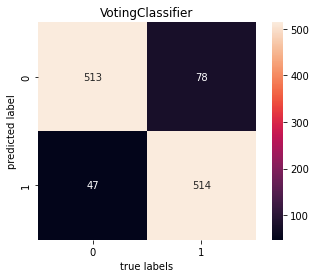

In [168]:
mat = confusion_matrix(y_test,eclf.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.title("VotingClassifier")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

## Make test predictions with best model 

In [103]:
data =  pd.read_csv("dataset/test.tsv",sep='\t',header=0)
print(data.head())
X_source_test = data['title']
X_source_test.head()

                                               title  is_fake
0  Роскомнадзор представил реестр сочетаний цвето...        1
1  Ночью под Минском на президентской горе Белара...        1
2  Бывший спичрайтер Юрия Лозы рассказал о трудно...        1
3  Сельская церковь, собравшая рекордно низкое ко...        1
4  Акции Google рухнули после объявления о переза...        0


0    Роскомнадзор представил реестр сочетаний цвето...
1    Ночью под Минском на президентской горе Белара...
2    Бывший спичрайтер Юрия Лозы рассказал о трудно...
3    Сельская церковь, собравшая рекордно низкое ко...
4    Акции Google рухнули после объявления о переза...
Name: title, dtype: object

####  String processing and Tf-idf again

In [64]:
X_test_processed = X_source_test.apply(preprocess_text_with_stopwords)
df = pd.DataFrame()
df['title'] = X_test_processed
df.to_csv('processed stemmed test text with stop words.csv')

In [104]:
X_test_processed = pd.read_csv('processed stemmed test text with stop words.csv')['title']
X_test_processed.head()

0    роскомнадзор представлять реестр сочетание цве...
1    ночь под минск на президентский гора беларашмо...
2    бывший спичрайтер юрий лоза рассказывать о тру...
3    сельский церковь собирать рекордно низкий коли...
4    акция google рухнуть после объявление о переза...
Name: title, dtype: object

In [105]:
vectorizer = CountVectorizer()
X_all = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names()
X_test = vectorizer.transform(X_test_processed)

C:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Apply model and make predictions  (best f1-score - Voting Classifier (SVC + MNB))

In [106]:
eclf.fit(X_all,y)

VotingClassifier(estimators=[('svc', SVC(C=2, probability=True)),
                             ('mnb', MultinomialNB(alpha=0.5))],
                 voting='soft')

In [107]:
y_pred = eclf.predict(X_test)

####  Wtite prediction results:  

In [108]:
data['is_fake'] = y_pred
data.to_csv("predictions.tsv",sep='\t',index=False)